In [1]:
#  used for implementing the algorithm
import numpy as np # linear algebra 
import copy # deep copies of objects -> estimators

#  estimator to ensemble with Adaboost:
from sklearn.tree import DecisionTreeClassifier

#  used for data handeling and visualisation
import pandas as pd # loading and transforming data
import matplotlib.pyplot as plt # visualisations
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # creating & visualising confusion matrices
from sklearn.model_selection import train_test_split # splitting data in train/test set

In [23]:
titanic_data = pd.read_csv(r"C:\Users\TEJKIRAN\Desktop\DataAnalytics_files\titanic.csv",usecols=["Survived", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]).dropna()
titanic_data["Sex"] = titanic_data["Sex"].astype("category").cat.codes
titanic_data["Embarked"] = titanic_data["Embarked"].astype("category").cat.codes

features = titanic_data.drop("Survived",axis=1)
labels = titanic_data["Survived"]

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2,random_state=42)

In [25]:
titanic_data.head()

,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,1,22.0,1,0,7.2500,2,0
1,0,38.0,1,0,71.2833,0,1
2,0,26.0,0,0,7.9250,2,1
3,0,35.0,1,0,53.1000,2,1
4,1,35.0,0,0,8.0500,2,0


In [69]:
class AdaBoostClassifier():
    def __init__(self,base_estimator=False,n_estimators=1,learning_rate=1):
        if base_estimator:
            self.base_estimator = base_estimator
        else:
            self.base_estimator = DecisionTreeClassifier(max_depth=1,max_leaf_nodes=2)
            
        
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        
        self.estimators = None
        self.estimator_weights = None
        
        #  to track performance, not nesseccary for the algorithm
        self.total_errors = None
        self.training_error = None
        self.validation_error = None
    
    def fit(self,X,y, X_val=None, y_val=None):
        #  resetting lists 
        self.estimators = []
        self.estimator_weights = []
        self.total_errors = []
        self.training_error = []
        self.validation_error = []
        lr = self.learning_rate
        
            #  0) initialise equal weights
        sample_weights = np.full(len(X), 1/len(X))
        
        for est_i in range(self.n_estimators):
            #  1) fit weak learner
            estimator = copy.copy(self.base_estimator)
            estimator.fit(X, y, sample_weights)
            
            #  2) calculate total error
            prediction = estimator.predict(X)
            total_error = np.where(prediction != y, sample_weights, 0).sum() 
            
            #  3) determine weight / amount of say in final prediction
            amount_of_say = lr * 0.5 * np.log((1 - total_error)/(total_error + 1e-10))

            #  3.5) save estimator and it's weight before going into the next iteration
            self.estimators.append(estimator)
            self.estimator_weights.append(amount_of_say)
            
            #  4) update weights
            sample_weights = np.where(prediction != y, sample_weights * np.exp(amount_of_say), sample_weights * np.exp(-1 * amount_of_say))
            
            #  5) renormalize weights
            sample_weights = sample_weights / sample_weights.sum()
            
            #  5.5) keep track of total- and training-error over iterations for documentation purposes
            self.total_errors.append(total_error)
            self.training_error.append(np.where(self.predict(X) != y, 1, 0).sum()/len(X))
            if type(X_val) != "NoneType":
                self.validation_error.append(np.where(self.predict(X_val) != y_val, 1, 0).sum()/len(X_val))
                
#             print(self.estimators)
#             print(self.estimator_weights)
#         print(self.total_errors)
#             print(self.training_error)
#             print(self.validation_error)
    
    def predict(self, X,value=None,verbose=False):
        """
        * every estimator makes his predictions in the shape (len(X)) -> [a, b, ..., len(X)]
        * stack prediction of estimators to have them row wise(each row corresponds to a sample) -> [[a1, a2], [b1, b2], ..., len(X)]
        * at each row apply the weighted majority vote previously discussed
        """
        predictions = np.stack([estimator.predict(X) for estimator in self.estimators], axis=1) 
#         print(predictions)
        weighted_majority_vote = lambda x: np.unique(x)[np.argmax([np.where(x==categ, self.estimator_weights, 0).sum() for categ in np.unique(x)])]
        return np.apply_along_axis(weighted_majority_vote, axis=1, arr=predictions)
            
    
                

In [66]:
base = DecisionTreeClassifier(max_depth=2, max_leaf_nodes=4)

adaboost = AdaBoostClassifier(base_estimator=base,n_estimators=100, learning_rate=1)
adaboost.fit(X_train, y_train, X_val, y_val)

#  make predictions:
predictions = adaboost.predict(X_val)
print(predictions)

[1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 1 1 0 1 0 0
 0 0 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 0 1 0 0 0 1 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0]


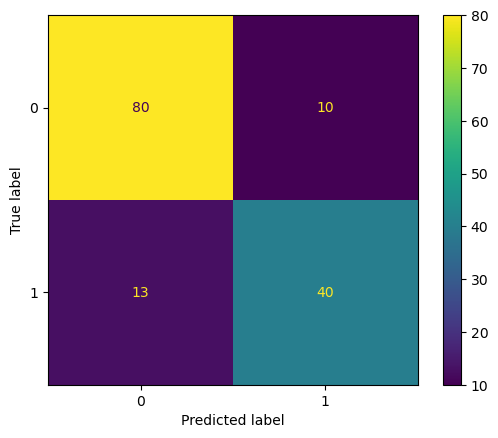

accuracy = 0.8391608391608392,
recall = 0.7547169811320755,
precision = 0.8,
f1-score = 0.7766990291262137


In [67]:
#  confusion matrix
cm = confusion_matrix(y_val, predictions, labels=[0, 1])
cm_displ = ConfusionMatrixDisplay(cm)
cm_displ.plot()
plt.show()

#  calculate accuracy:
accuracy = np.mean(predictions==y_val)

#  calculate recall:
recall = cm[1, 1]/cm[1, :].sum() # of the total actual positives, how much were classified correctly

#  calculate precision:
precision = cm[1, 1]/cm[:, 1].sum() # of all predicted positives, how much were True positives

#  not that neccessary for this problem, but for the completeness:
f1 = 2 * ((recall * precision)/(recall + precision)) 

print(f"accuracy = {accuracy},\nrecall = {recall},\nprecision = {precision},\nf1-score = {f1}")

<h1>Adabooost Characteristics</h1>

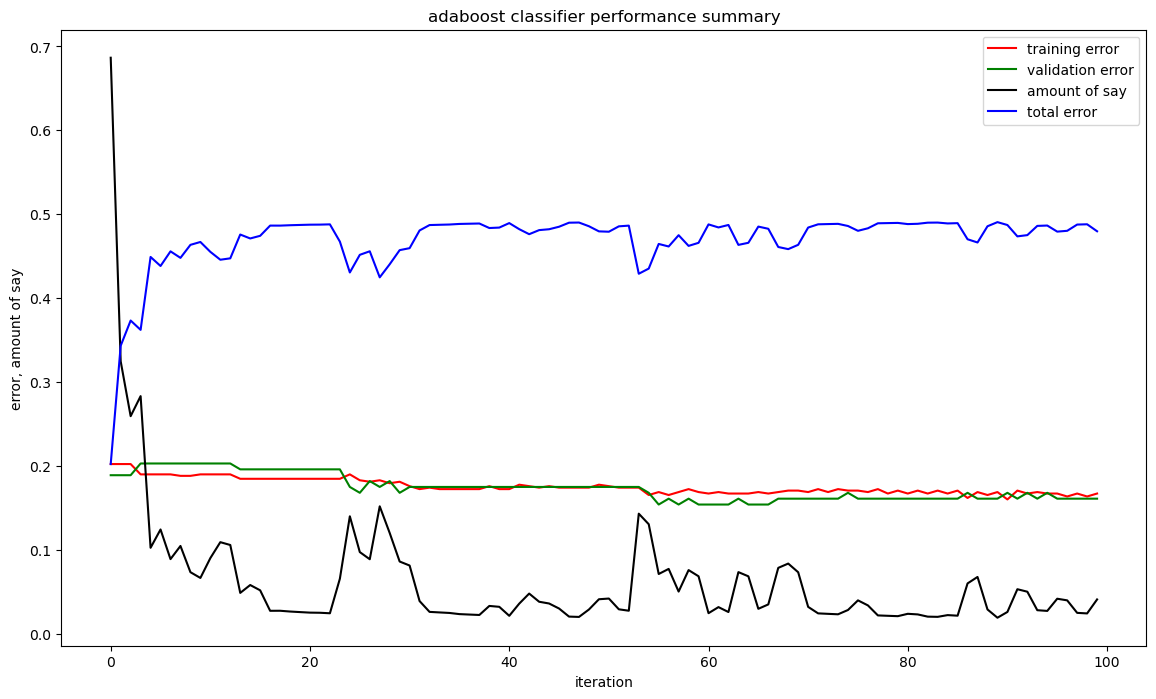

In [68]:
fig = plt.figure(figsize=(14, 8))

plt.plot(range(len(adaboost.training_error)), adaboost.training_error, color="red", label="training error")
plt.plot(range(len(adaboost.validation_error)), adaboost.validation_error, color="green", label="validation error")
plt.plot(range(len(adaboost.estimator_weights)), adaboost.estimator_weights, color="black", label="amount of say")
plt.plot(range(len(adaboost.total_errors)), adaboost.total_errors, color="blue", label="total error")

plt.xlabel("iteration")
plt.ylabel("error, amount of say")

plt.title("adaboost classifier performance summary")
plt.legend()
plt.show()

<b>Important things to take away:<b>

Adaboost is likely to overfit, this can be avoided with many regularisation techniques but has to be kept in mind
Adaboost performs extremely different on a problem depending on the base estimator used
Adaboost puts the most weight on estimators from early iterations since later estimators "fix" just small mistakes and don't have a good alone standing performance